## Import Library & Dataset Processing
* import necessary libraries 
* preprocess datasets - merging 

### Load Libraries & Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import nltk
from copy import deepcopy
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter

In [2]:
users = pd.read_csv('data/users.csv')
reviews = pd.read_csv('data/reviews.csv')

In [3]:
reviews.head()

,date,reviewID,reviewerID,reviewContent,rating,usefulCount,coolCount,funnyCount,flagged,restaurantID
0,9/22/2012,GtwU21YOQn-wf4vWRUIx6w,bNYesZ944s6IJVowOnB0iA,"Unlike Next, which we'd eaten at the previous ...",5,0,0,0,N,pbEiXam9YJL3neCYHGwLUA
1,9/22/2012,0LpVTc3,TRKxLC3y-ZvP45e5iilMtw,Probably one of the best meals I've had ever. ...,5,0,0,0,N,pbEiXam9YJL3neCYHGwLUA
2,9/19/2012,tljtLzf68Fkwf,0EMm8umAqXZzyhxNpL4M9g,Service was impeccable. Experience and present...,3,2,0,0,N,pbEiXam9YJL3neCYHGwLUA
3,9/6/2012,iSN,DlwexC7z88ymAzu45skODw,"The problem with places like this, given the e...",3,8,0,3,N,pbEiXam9YJL3neCYHGwLUA
4,9/9/2012,Jmwrh7,kW2dk1CWihmh3g7k9N2G8A,I have no idea how to write my review - dining...,5,1,2,0,N,pbEiXam9YJL3neCYHGwLUA


There are 4 classes of flagged reviews by Yelp recommendation system. 
* N - Reviews that are confirmed as not fake 
* Y - Reviews that are confirmed as fake (least frequent label)
* NR - Reviews that are not confirmed as fake but flagged for investigation (most frequent laabel)
* YR - Reviews that are suspected to be fake and require more review before confirmation 

In [4]:
reviews['flagged'].value_counts()

flagged
NR    402774
YR    318678
N      58716
Y       8303
Name: count, dtype: int64

### Merge dataset

In [5]:
## inner join 
merged = pd.merge(reviews, users, on='reviewerID')

In [6]:
# drop rows with NR and YR in flagged column since NR and YR are not confirmed reviews
merged_filtered = merged[~merged['flagged'].isin(['YR', 'NR'])]

In [7]:
merged_filtered['flagged'].value_counts()

flagged
N    20752
Y     6206
Name: count, dtype: int64

### Check for Duplicates

In [8]:
# check for duplicated reviewID
duplicate_count = merged['reviewID'].duplicated().sum()
print(duplicate_count)

0


### Rename columns

In [9]:
merged_filtered.rename(columns={'usefulCount_x': 'usefulCount_review', 
                   'coolCount_x': 'coolCount_review',
                   'funnyCount_x': 'funnyCount_review',
                   'usefulCount_y': 'usefulCount_user',
                   'coolCount_y': 'coolCount_user',
                   'funnyCount_y': 'funnyCount_user'}, inplace=True)

/var/folders/r6/8w9yhb292k5_7hy_mpvj9p780000gn/T/ipykernel_87074/1597501358.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_filtered.rename(columns={'usefulCount_x': 'usefulCount_review',


In [10]:
merged_filtered.columns

Index(['date', 'reviewID', 'reviewerID', 'reviewContent', 'rating',
       'usefulCount_review', 'coolCount_review', 'funnyCount_review',
       'flagged', 'restaurantID', 'name', 'location', 'yelpJoinDate',
       'friendCount', 'reviewCount', 'firstCount', 'usefulCount_user',
       'coolCount_user', 'funnyCount_user', 'complimentCount', 'tipCount',
       'fanCount'],
      dtype='object')

In [11]:
# drop identifier columns
merged_filtered.drop(columns=['reviewID', 'reviewerID', 'restaurantID', 'name'], inplace=True)

/var/folders/r6/8w9yhb292k5_7hy_mpvj9p780000gn/T/ipykernel_87074/2613519914.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_filtered.drop(columns=['reviewID', 'reviewerID', 'restaurantID', 'name'], inplace=True)


In [12]:
merged_filtered.columns 

Index(['date', 'reviewContent', 'rating', 'usefulCount_review',
       'coolCount_review', 'funnyCount_review', 'flagged', 'location',
       'yelpJoinDate', 'friendCount', 'reviewCount', 'firstCount',
       'usefulCount_user', 'coolCount_user', 'funnyCount_user',
       'complimentCount', 'tipCount', 'fanCount'],
      dtype='object')

In [13]:
data = deepcopy(merged_filtered)
df = deepcopy(merged_filtered)

In [14]:
# export to csv
data.to_csv('data/data.csv', index=False)

## Data Cleaning

### Data Information

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26958 entries, 0 to 430090
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   date                26958 non-null  object
 1   reviewContent       26956 non-null  object
 2   rating              26958 non-null  int64 
 3   usefulCount_review  26958 non-null  int64 
 4   coolCount_review    26958 non-null  int64 
 5   funnyCount_review   26958 non-null  int64 
 6   flagged             26958 non-null  object
 7   location            26949 non-null  object
 8   yelpJoinDate        26958 non-null  object
 9   friendCount         26958 non-null  int64 
 10  reviewCount         26958 non-null  int64 
 11  firstCount          26958 non-null  int64 
 12  usefulCount_user    26958 non-null  int64 
 13  coolCount_user      26958 non-null  int64 
 14  funnyCount_user     26958 non-null  int64 
 15  complimentCount     26958 non-null  int64 
 16  tipCount            26958 

In [16]:
df['flagged'].value_counts()  

flagged
N    20752
Y     6206
Name: count, dtype: int64

### Check for Missing Values

* there are 11 rows of missing values in reviewContent and location
* drop them because these fields are not quantitative field and difficult to impute 
* proportion of missing value is very little 11/26947

In [17]:
missing_values = df.isnull().sum()

missing_values = missing_values[missing_values > 0]
print("Columns with missing values:")
print(missing_values)

Columns with missing values:
reviewContent    2
location         9
dtype: int64


In [18]:
df = df.dropna(subset=['reviewContent', 'location'])

### Convert Date to Datetime Object
Columns : 
* date 
* yelpJoinDate

In [19]:
df['yelpJoinDate'] = pd.to_datetime(df['yelpJoinDate'], errors='coerce')

/var/folders/r6/8w9yhb292k5_7hy_mpvj9p780000gn/T/ipykernel_87074/149558587.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['yelpJoinDate'] = pd.to_datetime(df['yelpJoinDate'], errors='coerce')


In [20]:
# Extract year and month from yelpJoinDate
df['yelpJoinYear'] = df['yelpJoinDate'].dt.year
df['yelpJoinMonth'] = df['yelpJoinDate'].dt.month

In [21]:
df[['yelpJoinDate', 'yelpJoinYear', 'yelpJoinMonth']].head()

,yelpJoinDate,yelpJoinYear,yelpJoinMonth
0,2009-10-01,2009,10
1,2011-06-01,2011,6
2,2008-09-01,2008,9
3,2007-10-01,2007,10
4,2007-07-01,2007,7


In [22]:
# do the same to the date column

df['date'] = pd.to_datetime(df['date'], errors='coerce')

df['dateYear'] = df['date'].dt.year.astype('Int64')
df['dateMonth'] = df['date'].dt.month.astype('Int64')

df[['date', 'dateYear', 'dateMonth']].head()

,date,dateYear,dateMonth
0,2012-09-22,2012,9
1,2012-09-22,2012,9
2,2012-09-19,2012,9
3,2012-09-06,2012,9
4,2012-09-09,2012,9


In [23]:
# drop the date and yelpJoinDate columns
df.drop(columns=['date', 'yelpJoinDate'], inplace=True)

In [24]:
df.columns

Index(['reviewContent', 'rating', 'usefulCount_review', 'coolCount_review',
       'funnyCount_review', 'flagged', 'location', 'friendCount',
       'reviewCount', 'firstCount', 'usefulCount_user', 'coolCount_user',
       'funnyCount_user', 'complimentCount', 'tipCount', 'fanCount',
       'yelpJoinYear', 'yelpJoinMonth', 'dateYear', 'dateMonth'],
      dtype='object')

## Data Normality

* check whether numerical columns are normally distributed

Note : 'rating' is NOT a continous feature, it is a categorical feature --> conduct one hot encoding later

In [25]:
# List of continuous numerical columns
continuous_numerical_columns = [
    'usefulCount_review', 'coolCount_review', 'funnyCount_review',
    'friendCount', 'reviewCount', 'firstCount', 'usefulCount_user',
    'coolCount_user', 'funnyCount_user', 'complimentCount', 'tipCount',
    'fanCount'
]

### Histogram
* Visualize the numerical features to check for data normality (bell-shaped curve)
* Skewness - all numerical features are heavily skewed (right skewed = +ve skewed)

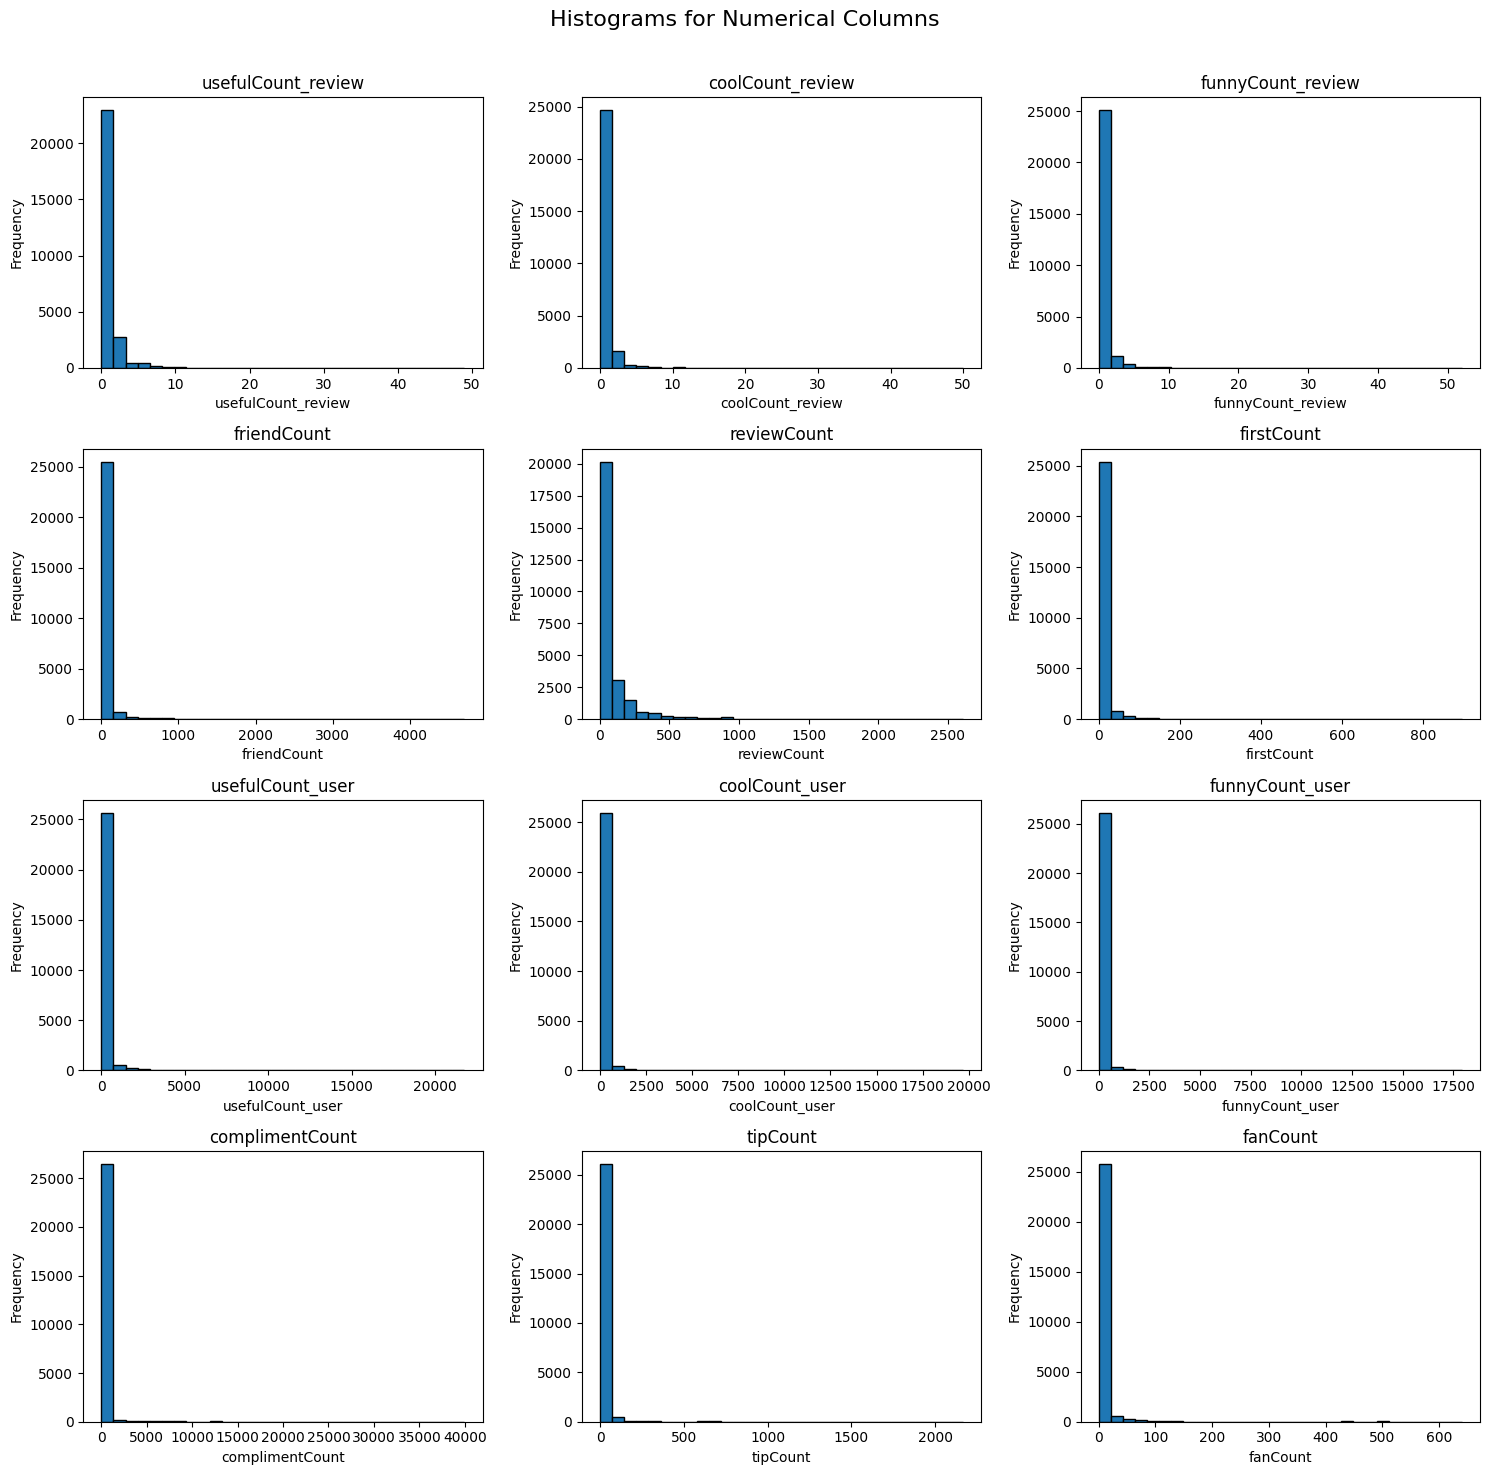

In [26]:
# historgam of numerical columns to visualize the distribution 

fig, axes = plt.subplots(4, 3, figsize=(15, 15))
fig.suptitle('Histograms for Numerical Columns', fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Generate histograms for each numerical column
for i, column in enumerate(continuous_numerical_columns):
    axes[i].hist(df[column].dropna(), bins=30, edgecolor='black')
    axes[i].set_title(column)
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(len(continuous_numerical_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to fit title
plt.show()

### Log Transformation 

Because the continous features are heavily skewed, therefore we apply log transformation before detecting outliers

In [27]:
# log transformation 
for column in continuous_numerical_columns:
    log_column_name = f"log_{column}"
    df[log_column_name] = np.log1p(df[column])

In [28]:
log_columns = [f"log_{column}" for column in continuous_numerical_columns]

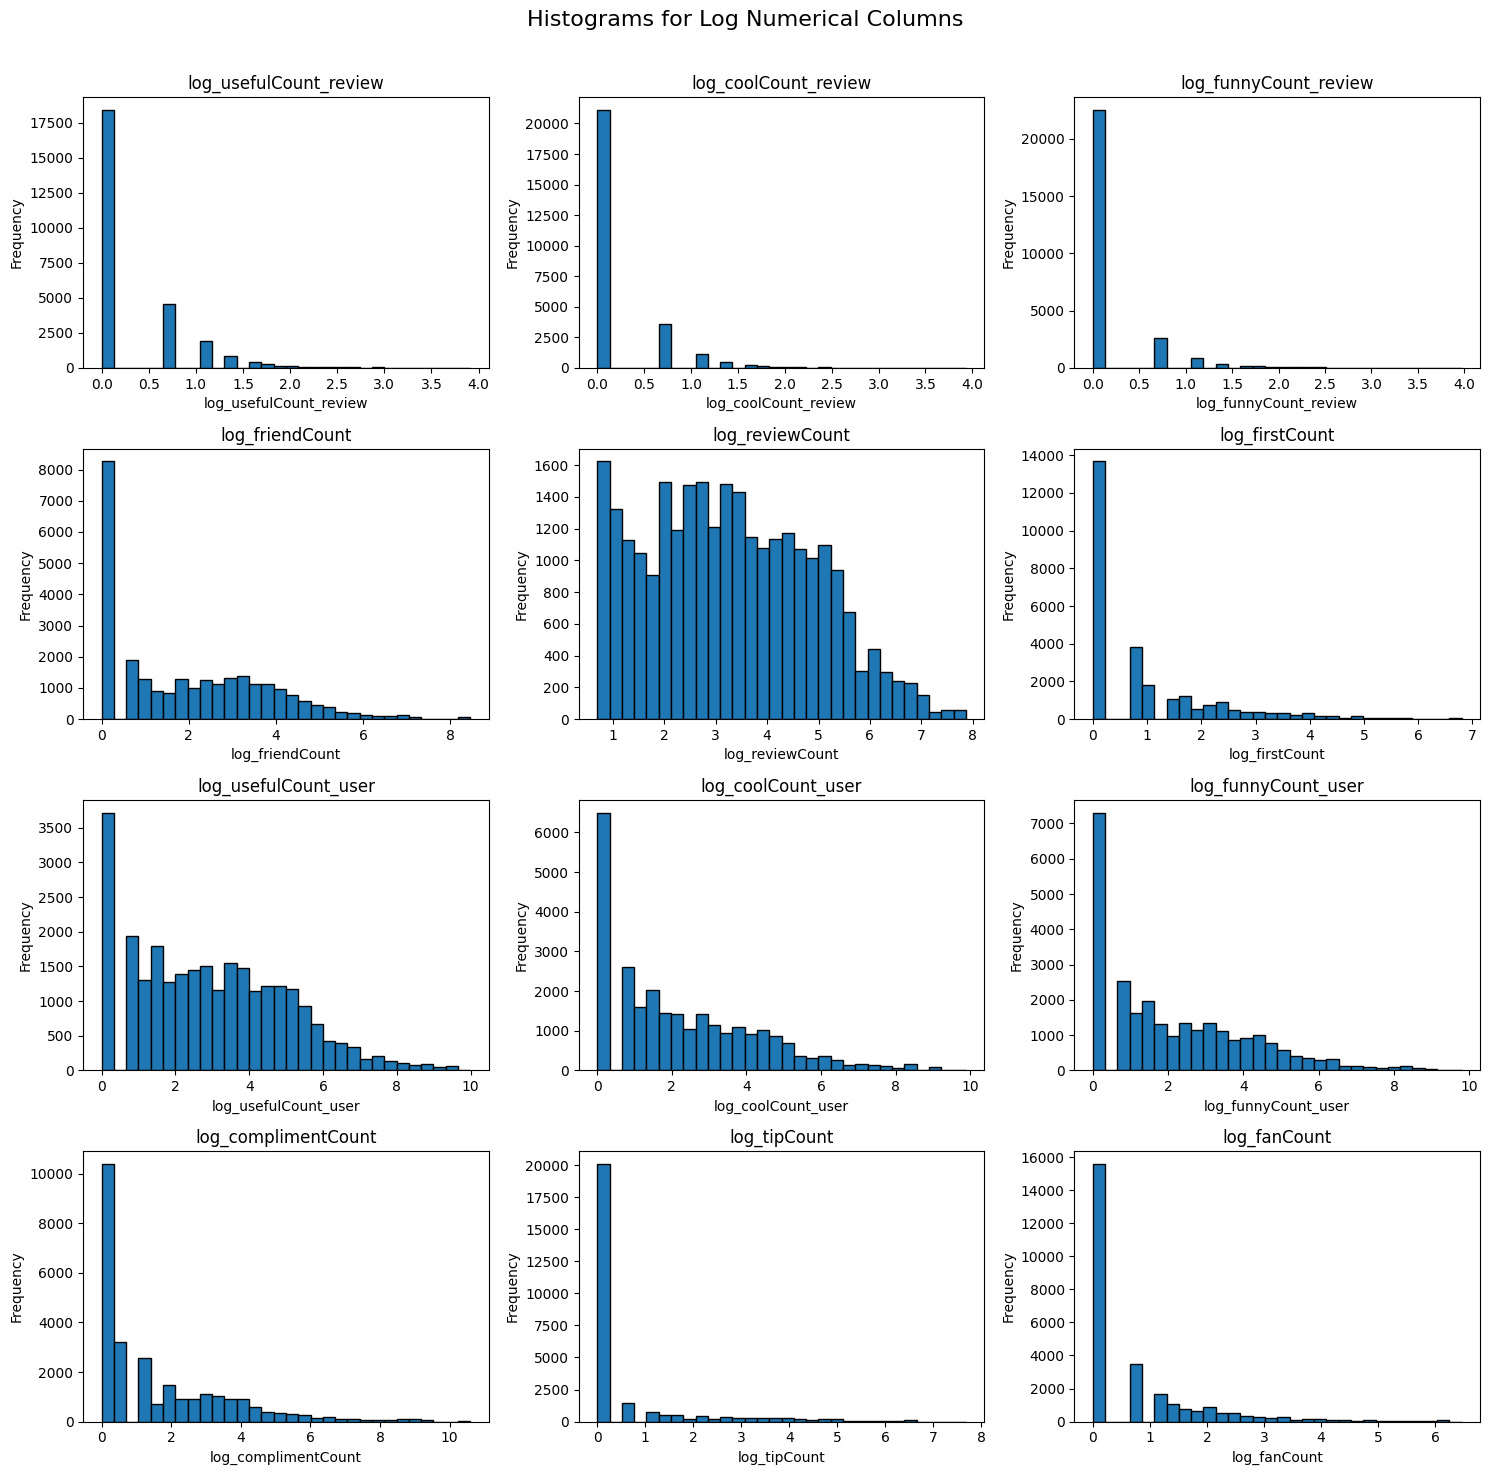

In [29]:
# historgam of log numerical columns to visualize the distribution after log transformation

fig, axes = plt.subplots(4, 3, figsize=(15, 15))
fig.suptitle('Histograms for Log Numerical Columns', fontsize=16)

axes = axes.flatten()

for i, column in enumerate(log_columns):
    axes[i].hist(df[column].dropna(), bins=30, edgecolor='black')
    axes[i].set_title(column)
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(len(log_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [30]:
df.drop(columns=continuous_numerical_columns, inplace=True)

## Outlier Detection

Detect outliers : 
* boxplot (visualize data to detect outlier)
* z-score : threshold=3: Z-score greater than 3 or less than -3 are considered outliers.
* Median Absolute Deviation (MAD) - data is not normally distributed


MAD the preferred way to detect outliers because : 

* The data is not normally distributed: MAD is more robust because it uses the median and median absolute deviation, which are less sensitive to extreme values or non-normal distributions.
* The data has heavy skewness or outliers: When your data is already skewed or contains a lot of natural outliers, MAD is preferred as it won’t be unduly influenced by those values.

For MAD, threshold +- 3.5 is suggested : https://stats.stackexchange.com/questions/123895/mad-formula-for-outlier-detection

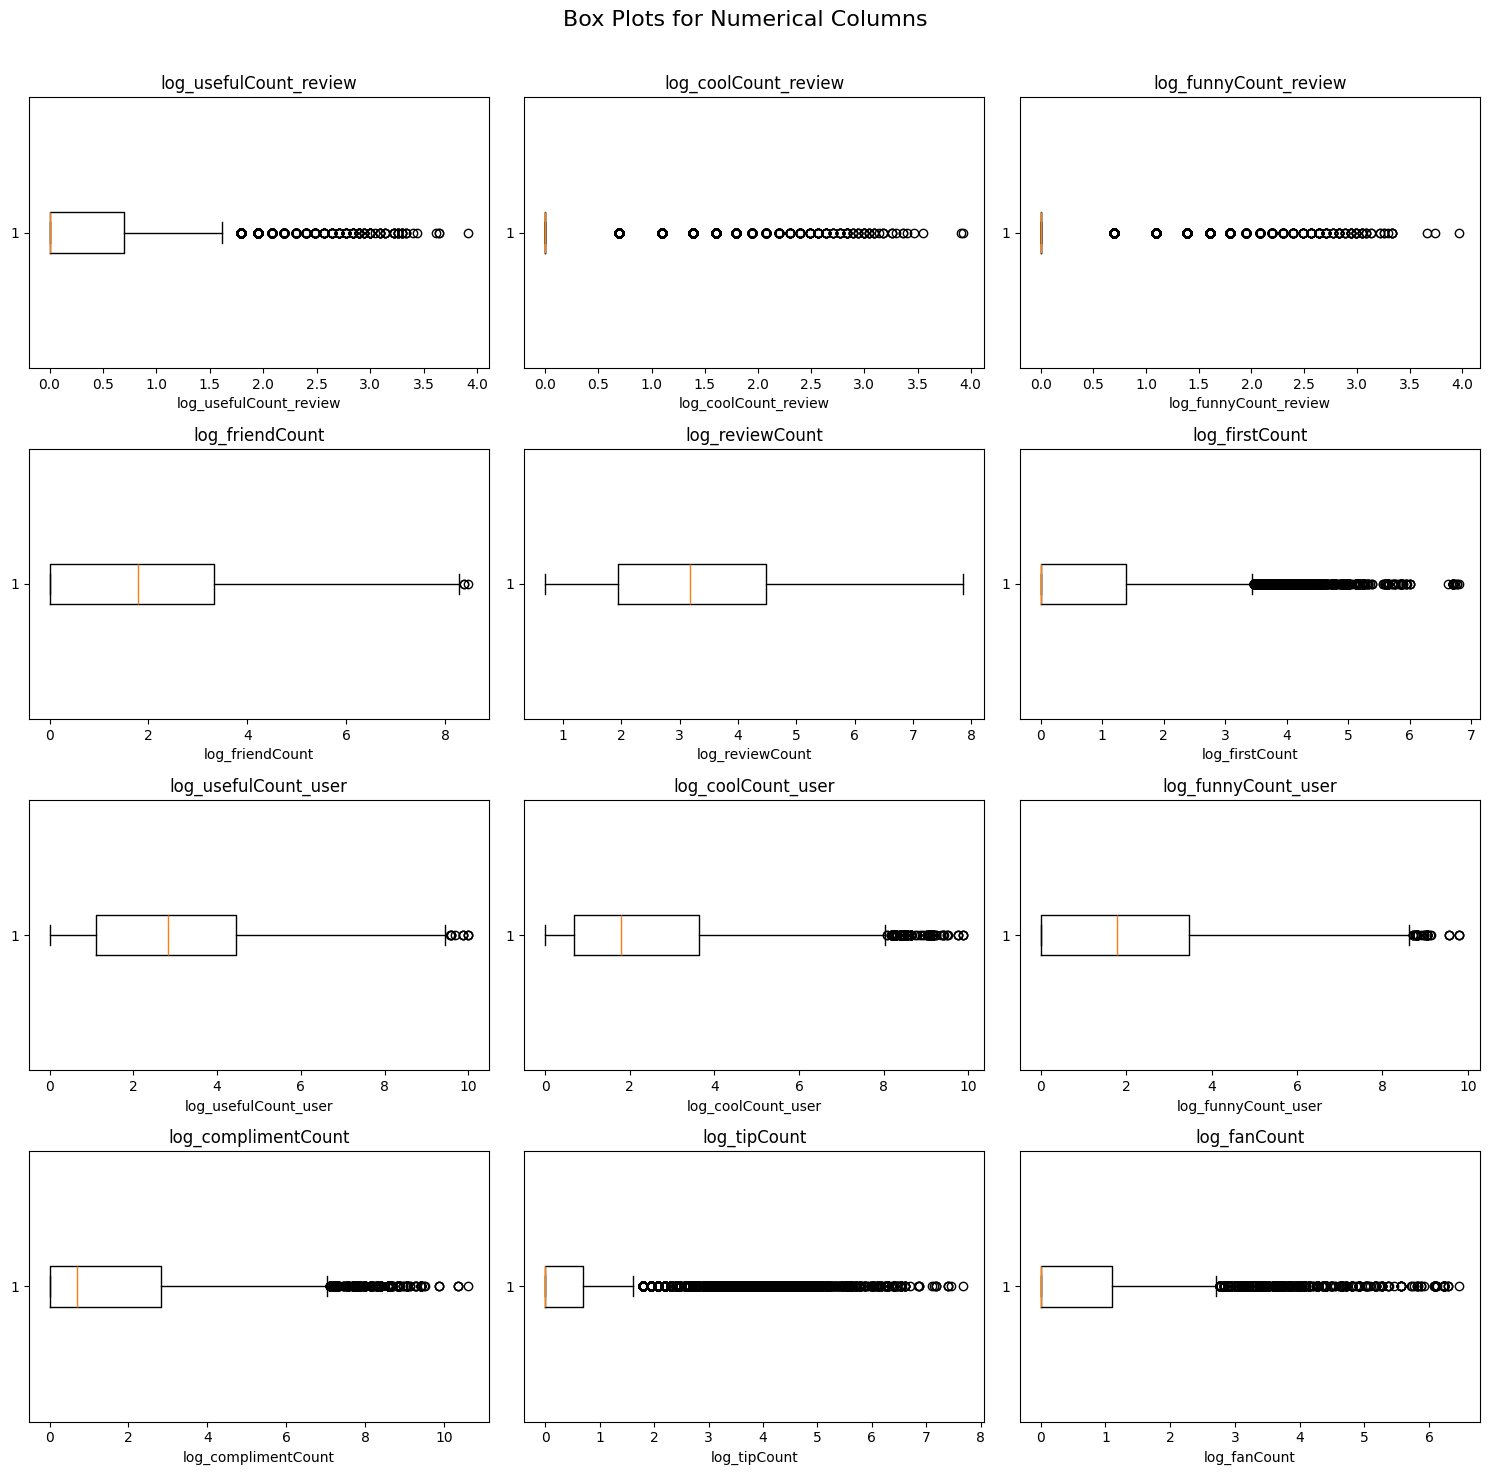

In [31]:
fig, axes = plt.subplots(4, 3, figsize=(15, 15))
fig.suptitle('Box Plots for Numerical Columns', fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Generate box plots for each numerical column
for i, column in enumerate(log_columns):
    axes[i].boxplot(df[column].dropna(), vert=False)
    axes[i].set_title(column)
    axes[i].set_xlabel(column)

# Hide any unused subplots
for j in range(len(log_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to fit title
plt.show()

In [32]:
# Function to detect outliers using the Z-score method
def detect_outliers_zscore(data, column, threshold=3):
    z_scores = zscore(data[column].dropna())
    outliers = data[(abs(z_scores) > threshold)]
    return len(outliers)

# Detect and print the number of outliers for each numerical column using the Z-score method
for column in log_columns:
    outlier_count = detect_outliers_zscore(df, column)
    print(f"Number of outliers in {column} using Z-score method: {outlier_count}")

# However, the Z-score method is sensitive to outliers itself and the log transformed data is not normally distributed.
# Therefore, we will use median and median absolute deviation (MAD) to detect outliers.

Number of outliers in log_usefulCount_review using Z-score method: 435
Number of outliers in log_coolCount_review using Z-score method: 705
Number of outliers in log_funnyCount_review using Z-score method: 669
Number of outliers in log_friendCount using Z-score method: 78
Number of outliers in log_reviewCount using Z-score method: 0
Number of outliers in log_firstCount using Z-score method: 428
Number of outliers in log_usefulCount_user using Z-score method: 65
Number of outliers in log_coolCount_user using Z-score method: 250
Number of outliers in log_funnyCount_user using Z-score method: 231
Number of outliers in log_complimentCount using Z-score method: 418
Number of outliers in log_tipCount using Z-score method: 783
Number of outliers in log_fanCount using Z-score method: 567


In [33]:
# Function to detect outliers using Modified Z-Score method (Median and MAD)
def detect_outliers_modified_zscore(data, column, threshold=3.5):
    median = np.median(data[column].dropna())
    mad = np.median(np.abs(data[column].dropna() - median))
    if mad == 0:  # To avoid division by zero
        return 0
    modified_z_scores = 0.6745 * (data[column] - median) / mad
    outliers = data[np.abs(modified_z_scores) > threshold]
    return len(outliers)

# Detect and print the number of outliers for each numerical column using the Modified Z-Score method
for column in log_columns:
    outlier_count = detect_outliers_modified_zscore(df, column)
    print(f"Number of outliers in {column} using Modified Z-Score method: {outlier_count}")

Number of outliers in log_usefulCount_review using Modified Z-Score method: 0
Number of outliers in log_coolCount_review using Modified Z-Score method: 0
Number of outliers in log_funnyCount_review using Modified Z-Score method: 0
Number of outliers in log_friendCount using Modified Z-Score method: 0
Number of outliers in log_reviewCount using Modified Z-Score method: 0
Number of outliers in log_firstCount using Modified Z-Score method: 0
Number of outliers in log_usefulCount_user using Modified Z-Score method: 0
Number of outliers in log_coolCount_user using Modified Z-Score method: 0
Number of outliers in log_funnyCount_user using Modified Z-Score method: 0
Number of outliers in log_complimentCount using Modified Z-Score method: 2660
Number of outliers in log_tipCount using Modified Z-Score method: 0
Number of outliers in log_fanCount using Modified Z-Score method: 0


In [34]:
# Function to detect outliers using Median and MAD
def get_outliers_mad(data, column, threshold=3.5):
    median = np.median(data[column].dropna())
    mad = np.median(np.abs(data[column].dropna() - median))
    if mad == 0:  # Avoid division by zero
        return data[[]]  # Return an empty DataFrame if no MAD can be calculated
    modified_z_scores = 0.6745 * (data[column] - median) / mad
    return data[np.abs(modified_z_scores) > threshold]

# Get the outliers for log_complimentCount
outliers_log_complimentCount = get_outliers_mad(df, 'log_complimentCount')

# Count 'Y' and 'N' in the flagged column
outliers_log_complimentCount['flagged'].value_counts()

flagged
N    2658
Y       2
Name: count, dtype: int64

### Handle Outliers 
We have 0.01% (271/26947) of extreme outliers of the log_complimentCount. Therefore, we use the capping (winsorize) method to handle the outliers. Cap the outliers to a defined max value which in our case is the 99th percentile to reduce their influence without removing them completely. 

Note : Not dropping outliers because they may contain useful information


In [35]:
# Calculate the 99th percentile value
percentile_99 = df['log_complimentCount'].quantile(0.99)

# Count the number of rows that are greater than or equal to the 99th percentile
rows_capped = df[df['log_complimentCount'] >= percentile_99].shape[0]

print(f"99th Percentile Value: {percentile_99}")
print(f"Number of Rows to be Capped: {rows_capped}")

99th Percentile Value: 8.289288323000317
Number of Rows to be Capped: 271


In [36]:
# Cap outliers at the 99th percentile
upper_limit_log_complimentCount = df['log_complimentCount'].quantile(0.99)
df['log_complimentCount'] = np.minimum(df['log_complimentCount'], upper_limit_log_complimentCount)

In [37]:
df.columns

Index(['reviewContent', 'rating', 'flagged', 'location', 'yelpJoinYear',
       'yelpJoinMonth', 'dateYear', 'dateMonth', 'log_usefulCount_review',
       'log_coolCount_review', 'log_funnyCount_review', 'log_friendCount',
       'log_reviewCount', 'log_firstCount', 'log_usefulCount_user',
       'log_coolCount_user', 'log_funnyCount_user', 'log_complimentCount',
       'log_tipCount', 'log_fanCount'],
      dtype='object')

## EDA - Categorical

### Rating

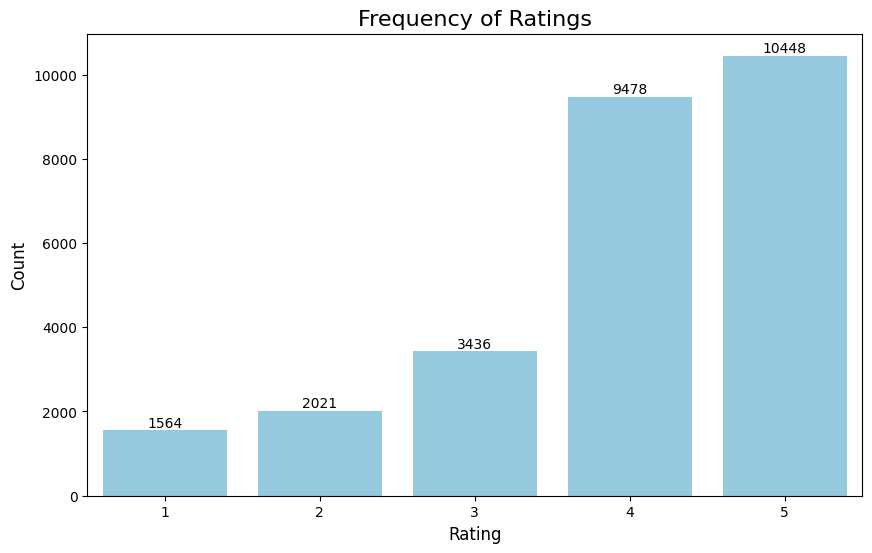

In [38]:
# Create a bar plot for ratings
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='rating', data=df, color='skyblue')  # Use color instead of palette

# Add bar labels with integer values
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',  # Convert height to integer
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', 
                xytext=(0, 5), textcoords='offset points')

# Customize the plot
plt.title('Frequency of Ratings', fontsize=16)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

### Rating By Year
* dateYear
* yelpJoinYear

Trend : decrease over years

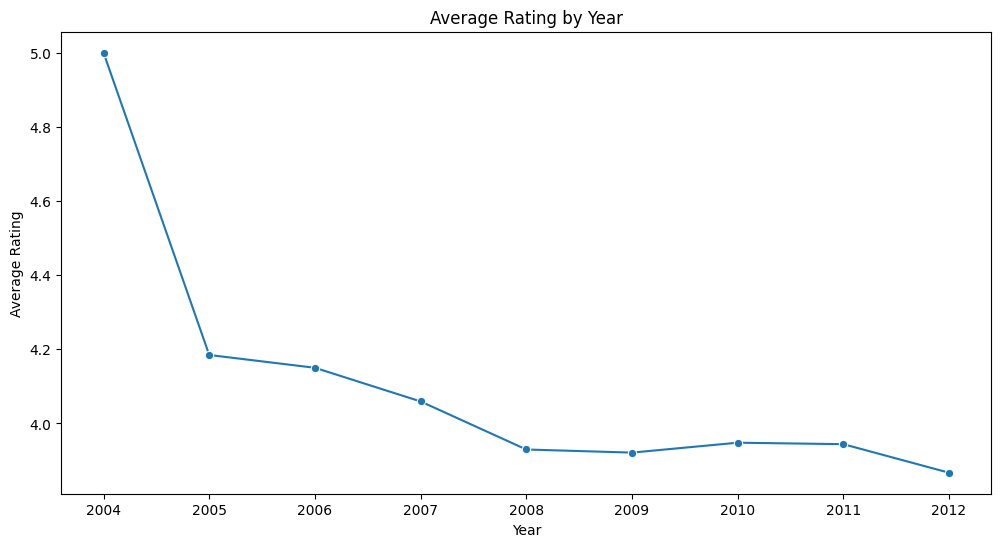

In [39]:
df_grouped = df.groupby('dateYear')['rating'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='dateYear', y='rating', data=df_grouped, marker='o')
plt.title('Average Rating by Year')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.show()

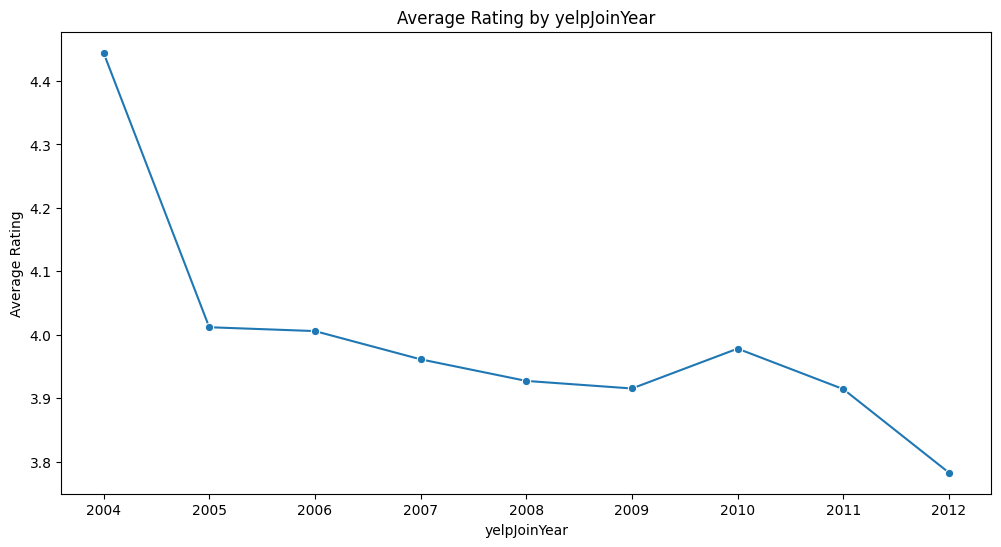

In [40]:
df_grouped = df.groupby('yelpJoinYear')['rating'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='yelpJoinYear', y='rating', data=df_grouped, marker='o')
plt.title('Average Rating by yelpJoinYear')
plt.xlabel('yelpJoinYear')
plt.ylabel('Average Rating')
plt.show()

### Frequency of Reviews by Date 
* dateYear 
* dateMonth

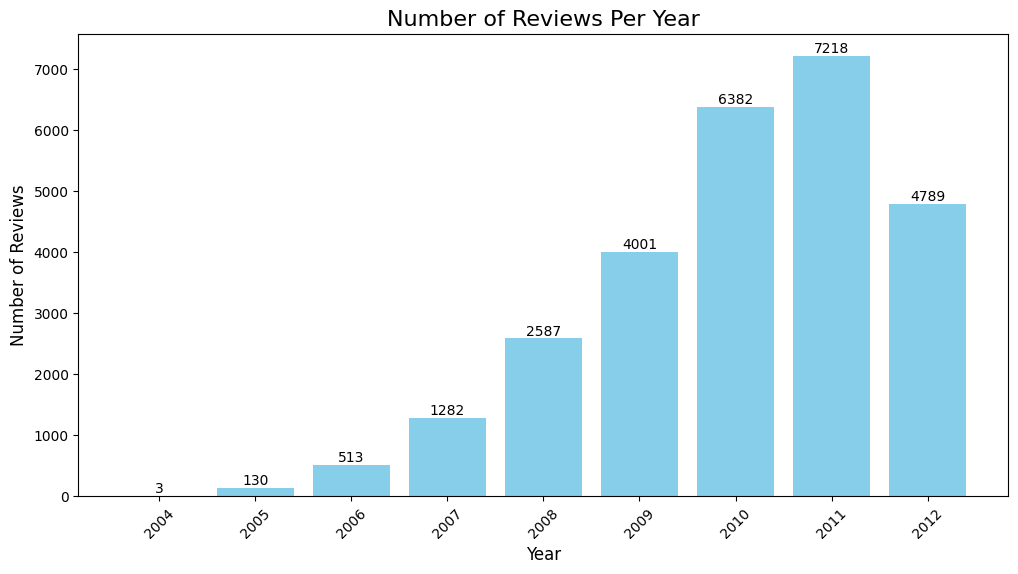

In [41]:
# Group
reviews_per_year = df.groupby('dateYear').size().reset_index(name='review_count')

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(reviews_per_year['dateYear'], reviews_per_year['review_count'], color='skyblue')

for bar in bars:
    plt.annotate(f'{int(bar.get_height())}',  # Get the height (count) and display it
                 xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),  # Position label
                 ha='center', va='bottom', fontsize=10, color='black')  # Align and format

plt.xticks(ticks=reviews_per_year['dateYear'], rotation=45)  # Ensure all years are displayed

plt.title('Number of Reviews Per Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.show()

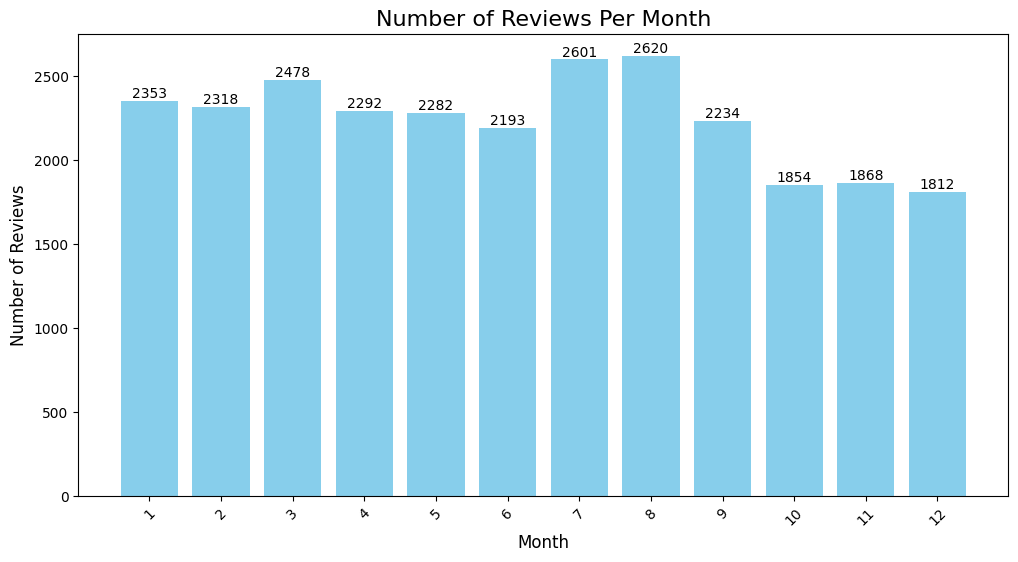

In [42]:
# Group
reviews_per_month = df.groupby('dateMonth').size().reset_index(name='review_count')

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(reviews_per_month['dateMonth'], reviews_per_month['review_count'], color='skyblue')

for bar in bars:
    plt.annotate(f'{int(bar.get_height())}',  # Get the height (count) and display it
                 xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),  # Position label
                 ha='center', va='bottom', fontsize=10, color='black')  # Align and format

plt.xticks(ticks=reviews_per_month['dateMonth'], rotation=45)  # Ensure all years are displayed

plt.title('Number of Reviews Per Month', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.show()

### Frequency of Reviews by yelpJoinDate 
* yelpJoinYear 
* yelpJoinMonth

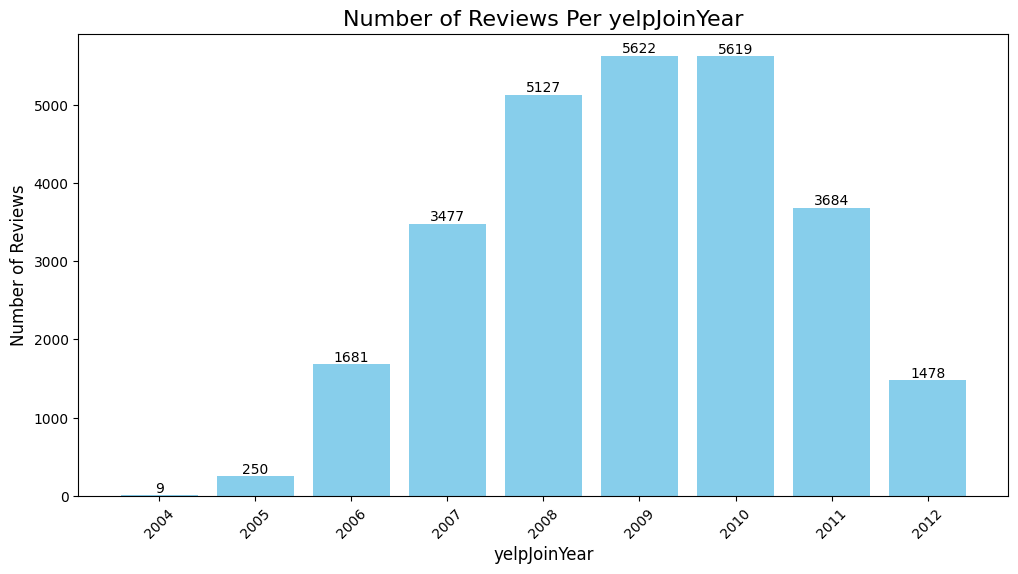

In [43]:
# Group
reviews_per_yelp_year = df.groupby('yelpJoinYear').size().reset_index(name='review_count')

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(reviews_per_yelp_year['yelpJoinYear'], reviews_per_yelp_year['review_count'], color='skyblue')

for bar in bars:
    plt.annotate(f'{int(bar.get_height())}',  # Get the height (count) and display it
                 xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),  # Position label
                 ha='center', va='bottom', fontsize=10, color='black')  # Align and format

plt.xticks(ticks=reviews_per_yelp_year['yelpJoinYear'], rotation=45)  # Ensure all years are displayed

plt.title('Number of Reviews Per yelpJoinYear', fontsize=16)
plt.xlabel('yelpJoinYear', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.show()

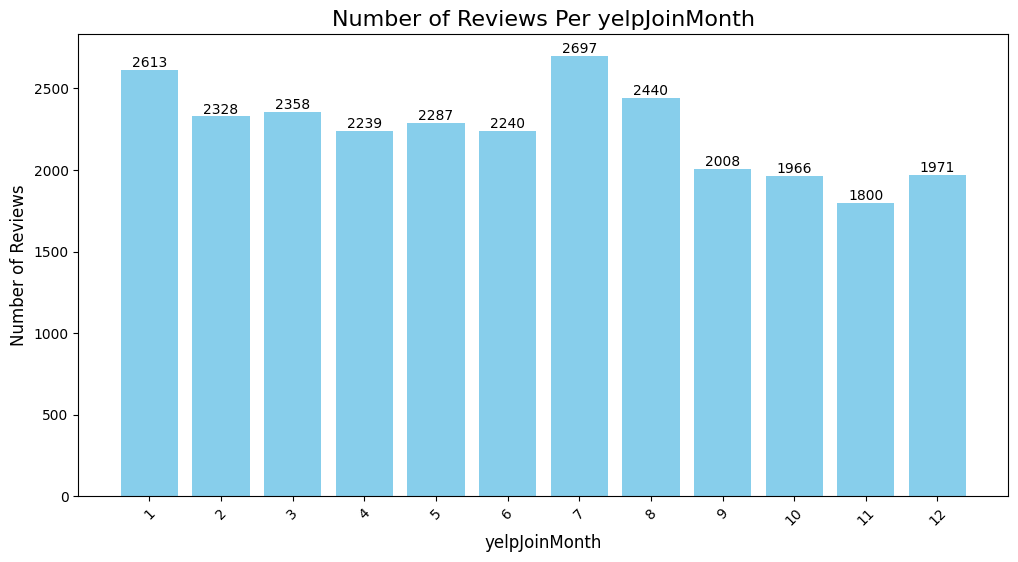

In [44]:
# Group
reviews_per_yelp_month = df.groupby('yelpJoinMonth').size().reset_index(name='review_count')

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(reviews_per_yelp_month['yelpJoinMonth'], reviews_per_yelp_month['review_count'], color='skyblue')

for bar in bars:
    plt.annotate(f'{int(bar.get_height())}',  # Get the height (count) and display it
                 xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),  # Position label
                 ha='center', va='bottom', fontsize=10, color='black')  # Align and format

plt.xticks(ticks=reviews_per_yelp_month['yelpJoinMonth'], rotation=45)  # Ensure all years are displayed

plt.title('Number of Reviews Per yelpJoinMonth', fontsize=16)
plt.xlabel('yelpJoinMonth', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.show()

### Proportion of Categorical Features x Target (Flagged)
* proportion of ratings x target --> half half for rating 1 
* proportion of year x target 
* proportion of yelpJoinYear x target --> display increasing trend over the years

In [45]:
pivot_table_rating = df.pivot_table(
    index='rating',
    columns='flagged',
    aggfunc='size',
    fill_value=0
)

pivot_table_rating = pivot_table_rating.div(pivot_table_rating.sum(axis=1), axis=0)

pivot_table_rating

flagged,N,Y
rating,,
1,0.484015,0.515985
2,0.759030,0.240970
3,0.852445,0.147555
4,0.824330,0.175670
5,0.738227,0.261773


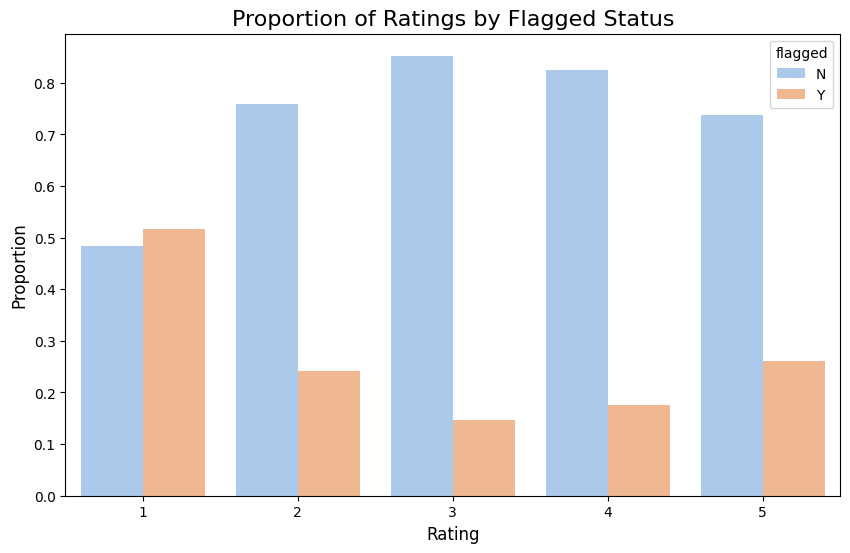

In [46]:
pivot_table_reset_rating = pivot_table_rating.reset_index().melt(id_vars='rating', value_name='proportion')

# Plot the proportions
plt.figure(figsize=(10, 6))
sns.barplot(data=pivot_table_reset_rating, x='rating', y='proportion', hue='flagged', palette='pastel')
plt.title('Proportion of Ratings by Flagged Status', fontsize=16)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.show()

In [47]:
pivot_table_dateYear = df.pivot_table(
    index='dateYear',
    columns='flagged',
    aggfunc='size',
    fill_value=0
)

pivot_table_dateYear = pivot_table_dateYear.div(pivot_table_dateYear.sum(axis=1), axis=0)

# Display the pivot table
pivot_table_dateYear

flagged,N,Y
dateYear,,
2004,1.000000,0.000000
2005,0.861538,0.138462
2006,0.844055,0.155945
2007,0.826833,0.173167
2008,0.766138,0.233862
2009,0.741315,0.258685
2010,0.753369,0.246631
2011,0.784843,0.215157
2012,0.776154,0.223846


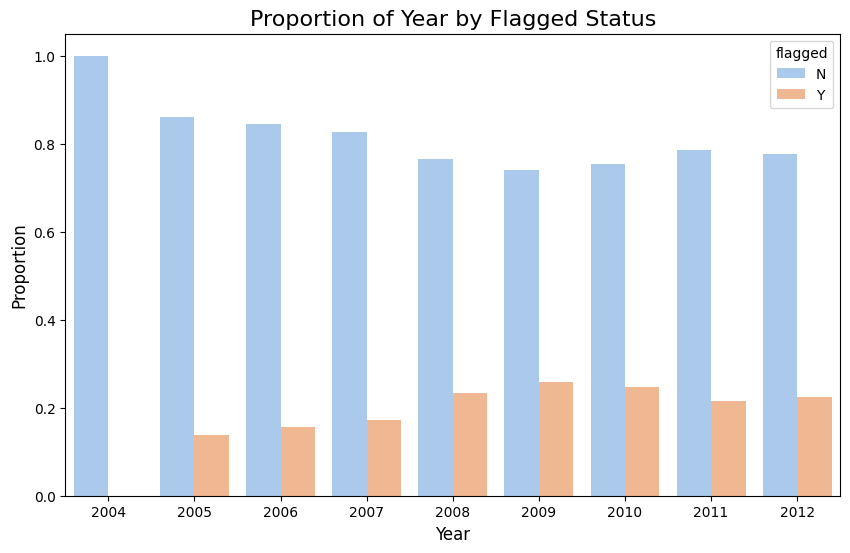

In [48]:
pivot_table_reset_dateYear = pivot_table_dateYear.reset_index().melt(id_vars='dateYear', value_name='proportion')

# Plot the proportions
plt.figure(figsize=(10, 6))
sns.barplot(data=pivot_table_reset_dateYear, x='dateYear', y='proportion', hue='flagged', palette='pastel')
plt.title('Proportion of Year by Flagged Status', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.show()

In [49]:
pivot_table_yelpYear = df.pivot_table(
    index='yelpJoinYear',
    columns='flagged',
    aggfunc='size',
    fill_value=0
)

pivot_table_yelpYear = pivot_table_yelpYear.div(pivot_table_yelpYear.sum(axis=1), axis=0)

pivot_table_yelpYear

flagged,N,Y
yelpJoinYear,,
2004,1.000000,0.000000
2005,0.924000,0.076000
2006,0.925640,0.074360
2007,0.899914,0.100086
2008,0.843768,0.156232
2009,0.777126,0.222874
2010,0.728777,0.271223
2011,0.637622,0.362378
2012,0.461434,0.538566


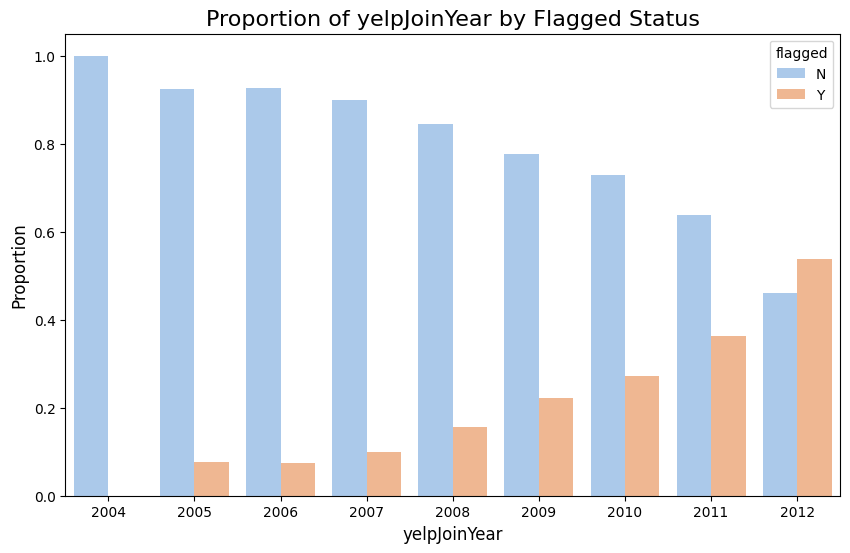

In [50]:
pivot_table_reset_yelpYear = pivot_table_yelpYear.reset_index().melt(id_vars='yelpJoinYear', value_name='proportion')

# Plot the proportions
plt.figure(figsize=(10, 6))
sns.barplot(data=pivot_table_reset_yelpYear, x='yelpJoinYear', y='proportion', hue='flagged', palette='pastel')
plt.title('Proportion of yelpJoinYear by Flagged Status', fontsize=16)
plt.xlabel('yelpJoinYear', fontsize=12)
plt.ylabel('Proportion', fontsize=12)
plt.show()

## EDA - Numerical

### Correlation Heatmap
* Understand the linear relationship between numerical features
* Identify multicollinearity

Findings : 
* reviews features (top left) have high correlation between each other 
* users features (center) have high correlation between each other 
* !! log_usefulCount_user, log_coolCount_user, log_funnyCount_user, log_complimentCount - are very highly correlated with each other (above 0.9) --> feature reduction (PCA) or combined to reduce multicollinearity

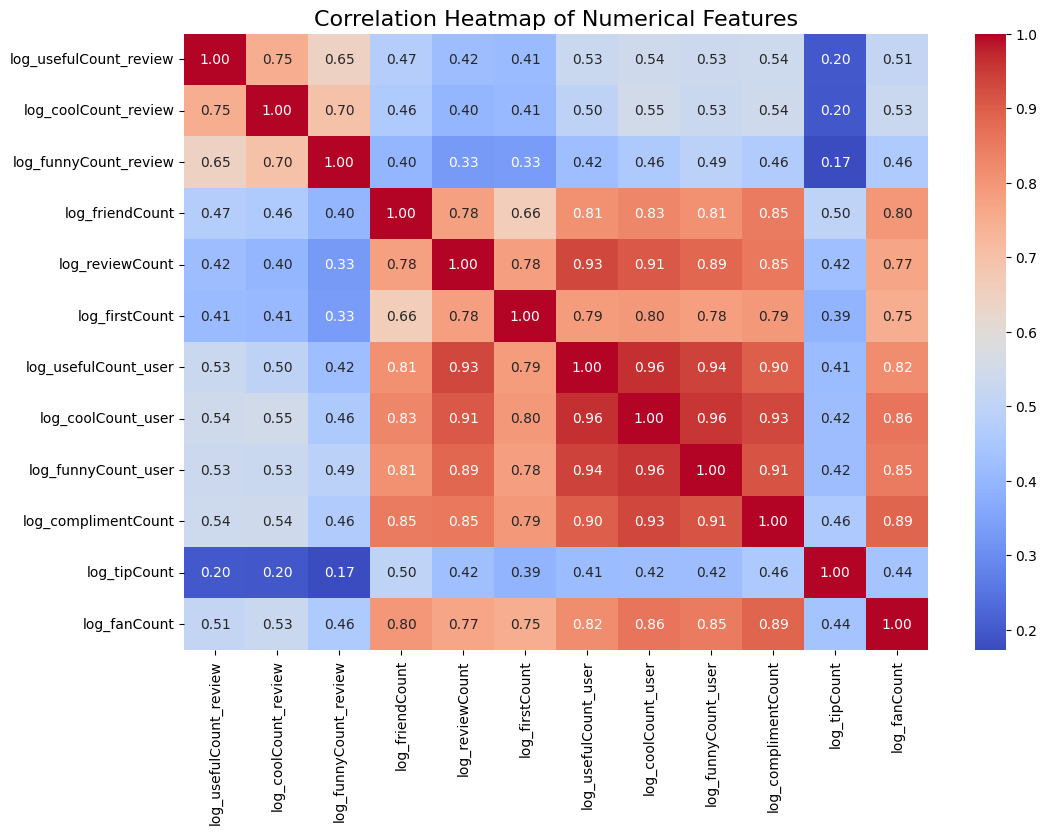

In [51]:
# Correlation Heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = df[log_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features', fontsize=16)
plt.show()

### Dealing with Multicollinearity

Measure multicollinearity quantitatively using the Variance Inflation Factor (VIF). A high VIF value indicates high multicollinearity.

* VIF > 10: High multicollinearity, consider addressing it.
* VIF between 5–10: Moderate multicollinearity, monitor closely.
* VIF < 5: Acceptable level.

In [52]:
# Calculate VIF
df_numerical = df[log_columns]
vif_data = pd.DataFrame()
vif_data['Feature'] = df_numerical.columns
vif_data['VIF'] = [variance_inflation_factor(df_numerical.values, i) for i in range(df_numerical.shape[1])]

# Display VIF
print(vif_data)

                   Feature        VIF
0   log_usefulCount_review   3.648340
1     log_coolCount_review   3.681683
2    log_funnyCount_review   2.607911
3          log_friendCount   9.137732
4          log_reviewCount  20.863971
5           log_firstCount   4.728873
6     log_usefulCount_user  60.395459
7       log_coolCount_user  55.206797
8      log_funnyCount_user  30.280028
9      log_complimentCount  19.408136
10            log_tipCount   1.669809
11            log_fanCount   7.593349


In [53]:
# remove those columns with VIF higher than 10
df.drop(columns=['log_reviewCount', 'log_usefulCount_user', 'log_coolCount_user', 'log_funnyCount_user', 'log_complimentCount'], inplace=True)

In [54]:
df.columns

Index(['reviewContent', 'rating', 'flagged', 'location', 'yelpJoinYear',
       'yelpJoinMonth', 'dateYear', 'dateMonth', 'log_usefulCount_review',
       'log_coolCount_review', 'log_funnyCount_review', 'log_friendCount',
       'log_firstCount', 'log_tipCount', 'log_fanCount'],
      dtype='object')

### Split the numerical columns 
* from reviews dataset (dateYear is used in trend)
* from users dataset (yelpJoinYear is used in trend)

In [55]:
log_numerical_reviews_columns = ['log_usefulCount_review', 
                                 'log_coolCount_review', 
                                 'log_funnyCount_review']

In [56]:
log_numerical_users_columns = ['log_friendCount', 
                               'log_firstCount', 
                               'log_tipCount', 
                               'log_fanCount']

### Trends of REVIEW numerical values over Year

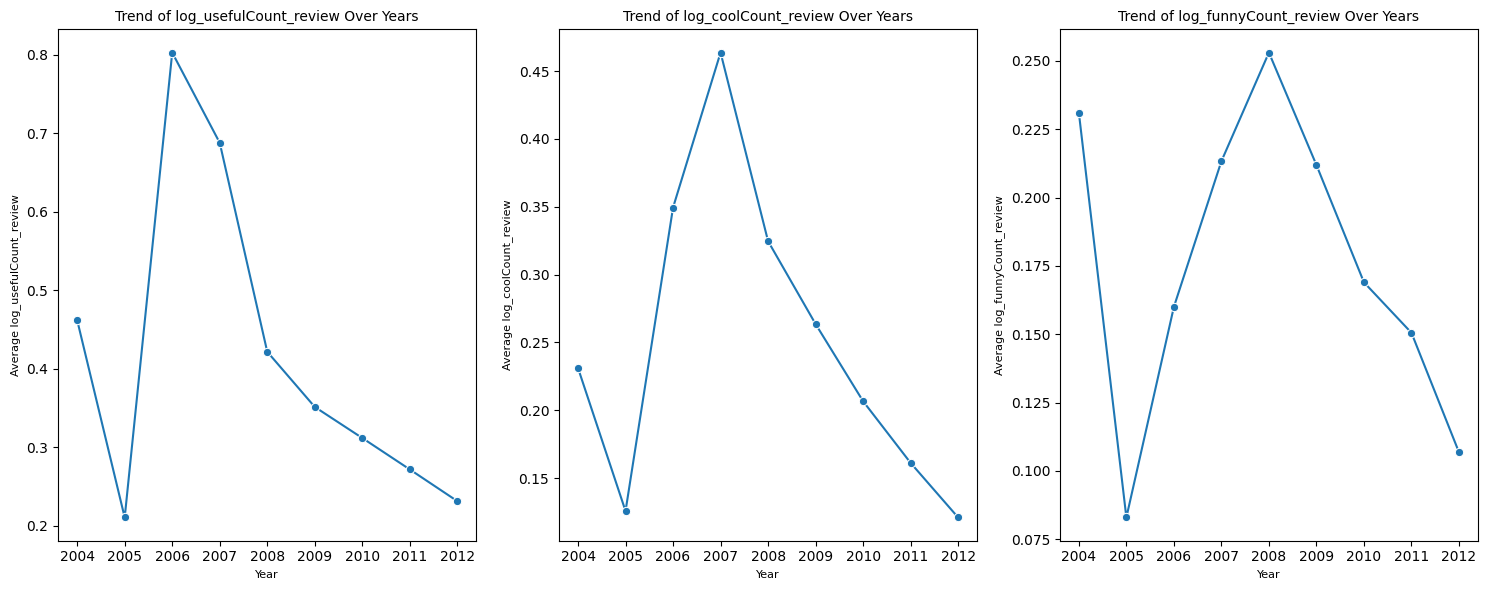

In [57]:
# Create a grid for multiple line plots
fig, axes = plt.subplots(1, 3, figsize=(15, 6)) 
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Plot trends for each log-transformed numerical column
for i, col in enumerate(log_numerical_reviews_columns):  # Replace numerical_columns with your log_columns list if needed
    trend_data = df.groupby('dateYear')[col].mean().reset_index()
    sns.lineplot(ax=axes[i], x='dateYear', y=col, data=trend_data, marker='o')
    axes[i].set_title(f'Trend of {col} Over Years', fontsize=10)
    axes[i].set_xlabel('Year', fontsize=8)
    axes[i].set_ylabel(f'Average {col}', fontsize=8)

# Hide unused subplots (if any)
for j in range(len(log_numerical_reviews_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Trends of USER numerical values over yelpJoinYear

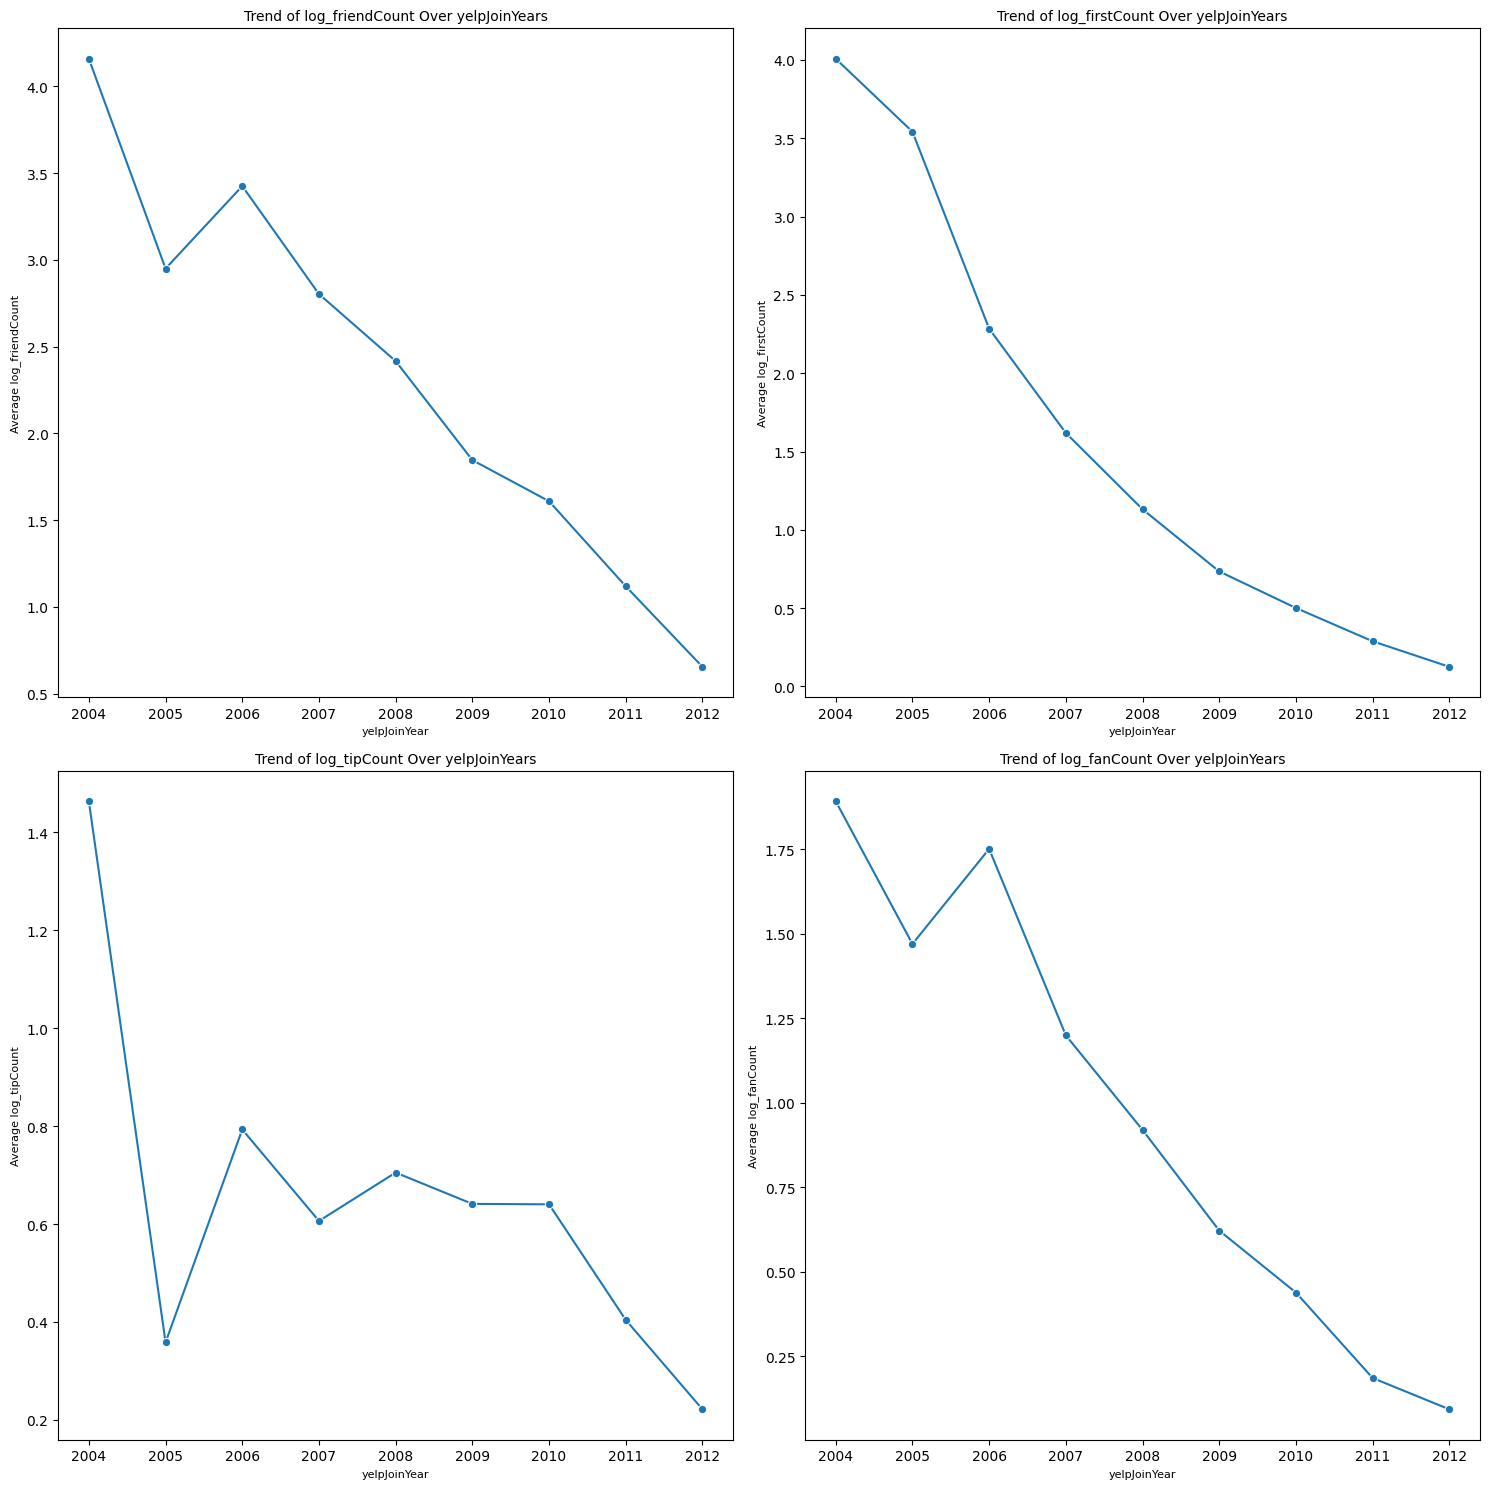

In [58]:
# Create a grid for multiple line plots
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Plot trends for each log-transformed numerical column
for i, col in enumerate(log_numerical_users_columns):  # Replace numerical_columns with your log_columns list if needed
    trend_data = df.groupby('yelpJoinYear')[col].mean().reset_index()
    sns.lineplot(ax=axes[i], x='yelpJoinYear', y=col, data=trend_data, marker='o')
    axes[i].set_title(f'Trend of {col} Over yelpJoinYears', fontsize=10)
    axes[i].set_xlabel('yelpJoinYear', fontsize=8)
    axes[i].set_ylabel(f'Average {col}', fontsize=8)

# Hide unused subplots (if any)
for j in range(len(log_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Location
* Top 10 states
* Group those states with < 100 rows as 'Other'

In [59]:
df['state'] = df['location'].apply(lambda x: x.split(',')[-1].strip() if isinstance(x, str) else None)

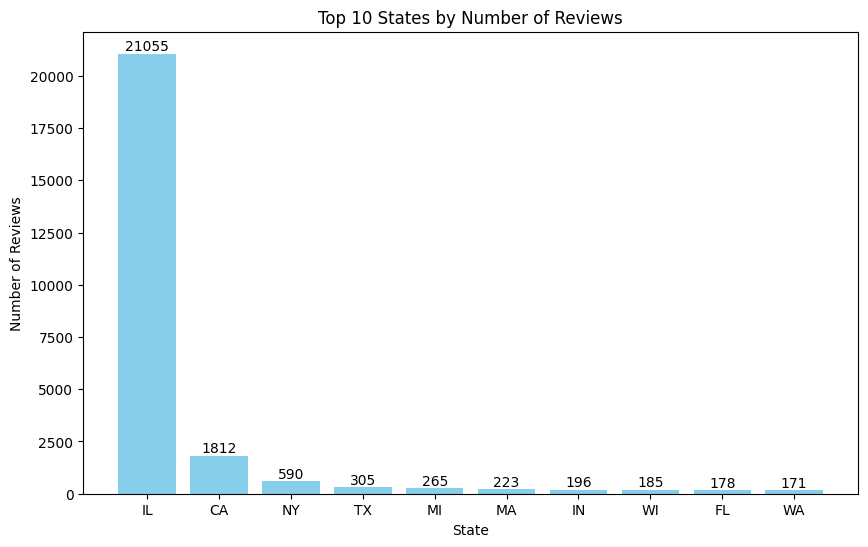

In [60]:
# Plot the top 10 states with bar labels
plt.figure(figsize=(10, 6))
state_counts = df['state'].value_counts().head(10)
bars = plt.bar(state_counts.index, state_counts.values, color='skyblue')

# Add bar labels
for bar in bars:
    plt.annotate(f'{int(bar.get_height())}',  # Get the height (count) and display as integer
                 xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),  # Position above bar
                 ha='center', va='bottom', fontsize=10)

plt.title('Top 10 States by Number of Reviews')
plt.xlabel('State')
plt.ylabel('Number of Reviews')
plt.show()

In [61]:
# group those less than 100 as 'Other
state_counts = df['state'].value_counts()
df['state'] = df['state'].apply(lambda x: x if state_counts[x] >= 100 else 'Other')

print("Updated State Value Counts:\n", df['state'].value_counts())


Updated State Value Counts:
 state
IL       21055
CA        1812
Other      875
NY         590
TX         305
MI         265
MA         223
IN         196
WI         185
FL         178
WA         171
OH         167
PA         128
AZ         126
MN         122
MO         118
DC         112
CO         111
VA         105
GA         103
Name: count, dtype: int64


In [62]:
# drop the location column
df.drop(columns=['location'], inplace=True)

## Text Analysis
Text feature - reviewContent
* Text Preprocessing & Cleaning
* Text analysis 
* Sentiment Analysis


### Text Preprocessing & Cleaning

* Remove HTML Tags: If the reviews have embedded HTML tags.
* Lowercase Conversion: Convert all text to lowercase to ensure uniformity.
* Remove Punctuation: Strip punctuation marks to focus on words.
* Remove Numbers: Exclude numerical data unless relevant to analysis.
* Remove Stopwords: Eliminate common words like “and,” “the,” etc., using a predefined stopword list.
* Tokenization: Split the text into individual words or tokens.
* Stemming or Lemmatization: Reduce words to their root form (e.g., “running” → “run”).

In [63]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lihuicham/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/lihuicham/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/lihuicham/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/lihuicham/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/lihuicham/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [64]:
# Initialize lemmatizer and stopword list
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Preprocessing function
def preprocess_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Lowercase conversion
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenization
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing
df['reviewContent'] = df['reviewContent'].apply(preprocess_text)

### Text Analysis
* Word Count: Count the number of words in each review.
* Character Count: Count the total characters in each review.
* Sentiment Analysis: Use libraries like TextBlob or VADER to determine if a review is positive, negative, or neutral.
* N-Gram Analysis: Analyze frequent bigrams (pairs of words) or trigrams (triplets of words).

In [67]:
# Word count
df['word_count'] = df['reviewContent'].apply(lambda x: len(x.split()))

# Character count
df['char_count'] = df['reviewContent'].apply(len)


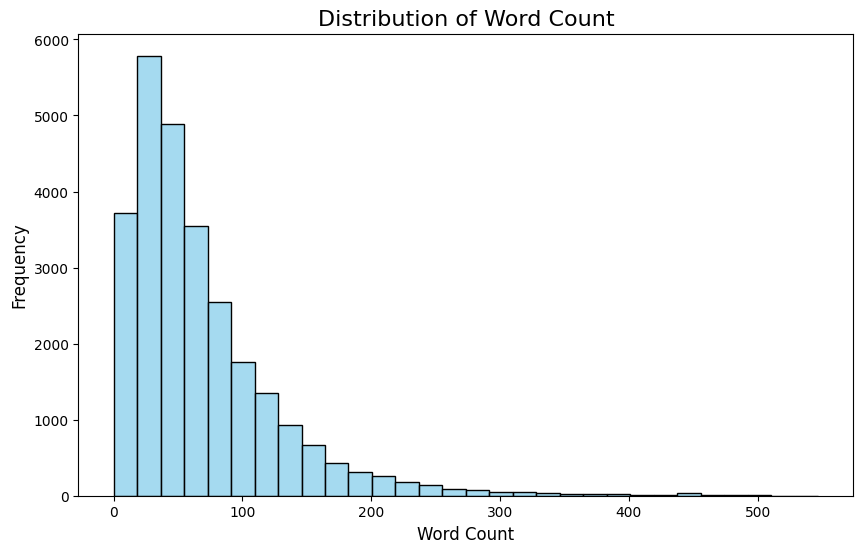

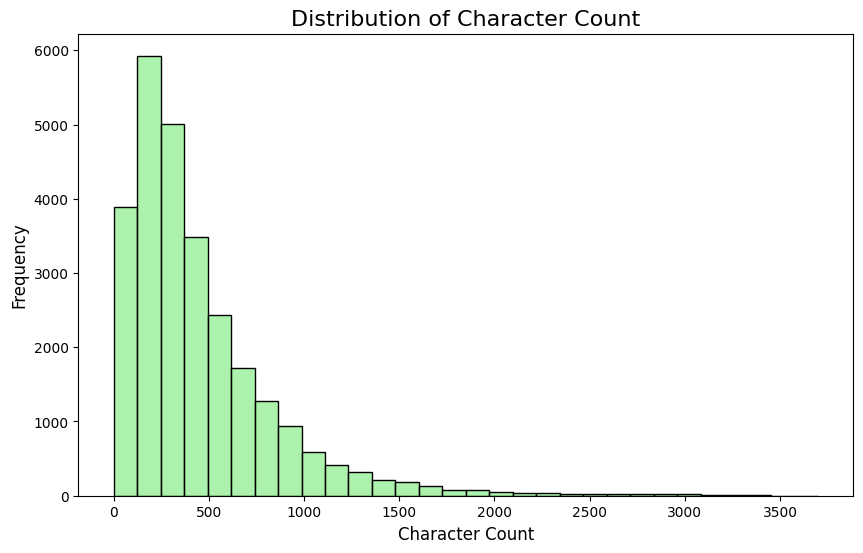

In [68]:
# Visualize the distribution of word count
plt.figure(figsize=(10, 6))
sns.histplot(df['word_count'], bins=30, color='skyblue')
plt.title('Distribution of Word Count', fontsize=16)
plt.xlabel('Word Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Visualize the distribution of character count
plt.figure(figsize=(10, 6))
sns.histplot(df['char_count'], bins=30, color='lightgreen')
plt.title('Distribution of Character Count', fontsize=16)
plt.xlabel('Character Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

### Sentiment Analysis
Package used : TextBlob

* Polarity [-1.0 to 1.0] : -1.0 = extremely negative sentiment, 0.0 = neutral sentiment and 1.0 = extremely positive sentiment
* Subjectivity [0.0 to 1.0] : 0.0 = completely objective (fact-based), 1.0 = completely subjective (opinion-based)

Distribution of polarity and sentiment are bell shaped (normally distributed), similar pattern for N (real) and Y (fake) reviews


In [69]:
# Function to compute polarity and subjectivity
def analyze_sentiment(text):
    blob = TextBlob(text)
    return pd.Series({'polarity': blob.sentiment.polarity, 'subjectivity': blob.sentiment.subjectivity})

# Apply to the reviewContent column
df[['polarity', 'subjectivity']] = df['reviewContent'].apply(analyze_sentiment)

In [70]:
df[['reviewContent', 'polarity', 'subjectivity']].head()

,reviewContent,polarity,subjectivity
0,unlike next wed eaten previous night dish comp...,0.151420,0.526901
1,probably one best meal ive ever performance fo...,0.466667,0.566667
2,service impeccable experience presentation coo...,0.413333,0.720000
3,problem place like given exhorbitant cost medi...,0.120548,0.515464
4,idea write review dining alinea brings whole d...,0.132331,0.587594


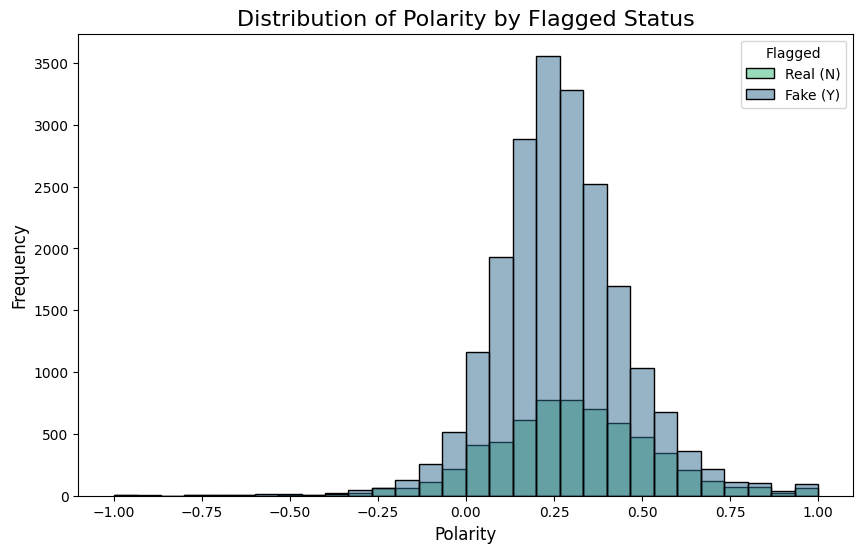

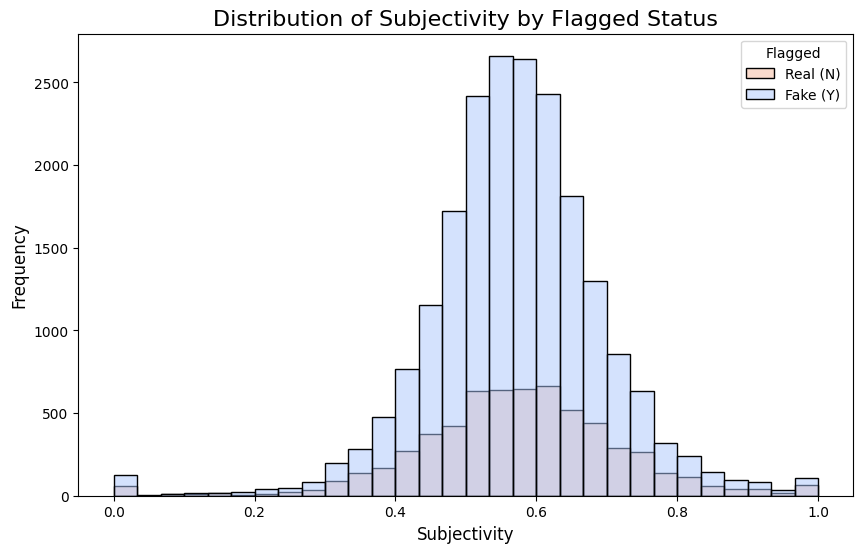

In [71]:
# Visualize polarity distribution by flagged status with proper legend
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='polarity', bins=30, hue='flagged', palette='viridis', common_norm=False)
plt.title('Distribution of Polarity by Flagged Status', fontsize=16)
plt.xlabel('Polarity', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(title='Flagged', labels=['Real (N)', 'Fake (Y)'])
plt.show()

# Visualize subjectivity distribution by flagged status with proper legend
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='subjectivity', bins=30, hue='flagged', palette='coolwarm', common_norm=False)
plt.title('Distribution of Subjectivity by Flagged Status', fontsize=16)
plt.xlabel('Subjectivity', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(title='Flagged', labels=['Real (N)', 'Fake (Y)'])
plt.show()

In [72]:
# Median polarity and subjectivity for flagged reviews
sentiment_by_flagged = df.groupby('flagged')[['polarity', 'subjectivity']].median()
sentiment_by_flagged

,polarity,subjectivity
flagged,,
N,0.261757,0.570284
Y,0.297222,0.575000


        polarity  subjectivity
rating                        
1       0.013929      0.521831
2       0.120876      0.535869
3       0.210734      0.553695
4       0.298711      0.576254
5       0.348897      0.586086


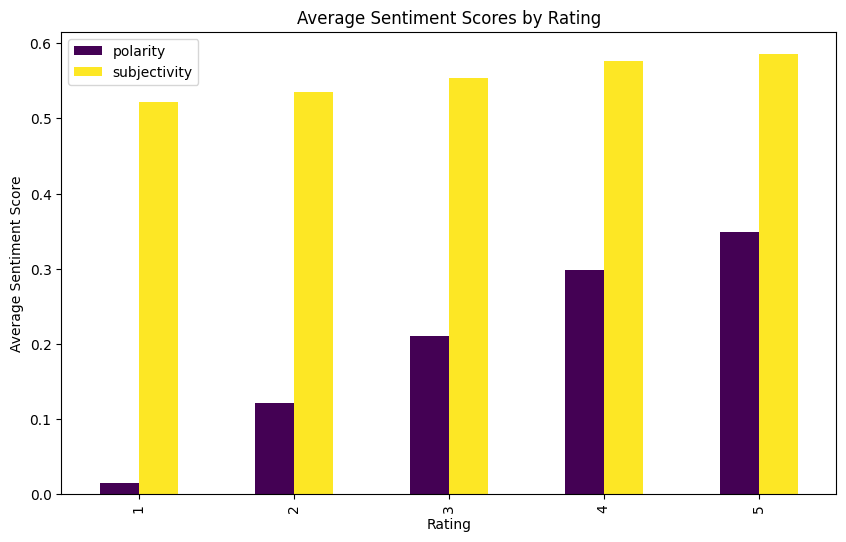

In [73]:
# Average polarity and subjectivity by rating
sentiment_by_rating = df.groupby('rating')[['polarity', 'subjectivity']].mean()
print(sentiment_by_rating)

# Visualize sentiment by rating
sentiment_by_rating.plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title('Average Sentiment Scores by Rating')
plt.xlabel('Rating')
plt.ylabel('Average Sentiment Score')
plt.show()

### Part of Speech Tagging
* hue='flagged': Splits the data by the flagged column (N or Y) and overlays the distributions.
* common_norm=False: Ensures the distributions for “N” and “Y” are scaled independently, so the raw count imbalance doesn’t skew the visualization.

Distribution of noun count, verb count and adjective count are positively skewed (right skewed), similar pattern for N (real) and Y (fake) reviews

In [74]:
# Function to count POS tags
def pos_tagging(text):
    tokens = nltk.word_tokenize(text)  # Tokenize the text
    pos_tags = nltk.pos_tag(tokens)  # POS tagging
    pos_counts = Counter(tag for word, tag in pos_tags)  # Count POS tags
    return pos_counts

# Apply POS tagging to the cleaned reviews
df['pos_counts'] = df['reviewContent'].apply(pos_tagging)

# Extract counts for specific POS tags (e.g., nouns, verbs, adjectives)
df['noun_count'] = df['pos_counts'].apply(lambda x: x.get('NN', 0) + x.get('NNS', 0))  # Singular & Plural Nouns
df['verb_count'] = df['pos_counts'].apply(lambda x: x.get('VB', 0) + x.get('VBD', 0) + x.get('VBG', 0) + x.get('VBN', 0) + x.get('VBP', 0) + x.get('VBZ', 0))  # Verbs
df['adj_count'] = df['pos_counts'].apply(lambda x: x.get('JJ', 0) + x.get('JJR', 0) + x.get('JJS', 0))  # Adjectives

# Display the updated DataFrame with POS counts
df[['reviewContent', 'noun_count', 'verb_count', 'adj_count']].head()

,reviewContent,noun_count,verb_count,adj_count
0,unlike next wed eaten previous night dish comp...,182,114,88
1,probably one best meal ive ever performance fo...,14,5,7
2,service impeccable experience presentation coo...,16,5,3
3,problem place like given exhorbitant cost medi...,96,26,56
4,idea write review dining alinea brings whole d...,42,9,22


In [75]:
df.drop(columns=['pos_counts'], inplace=True)

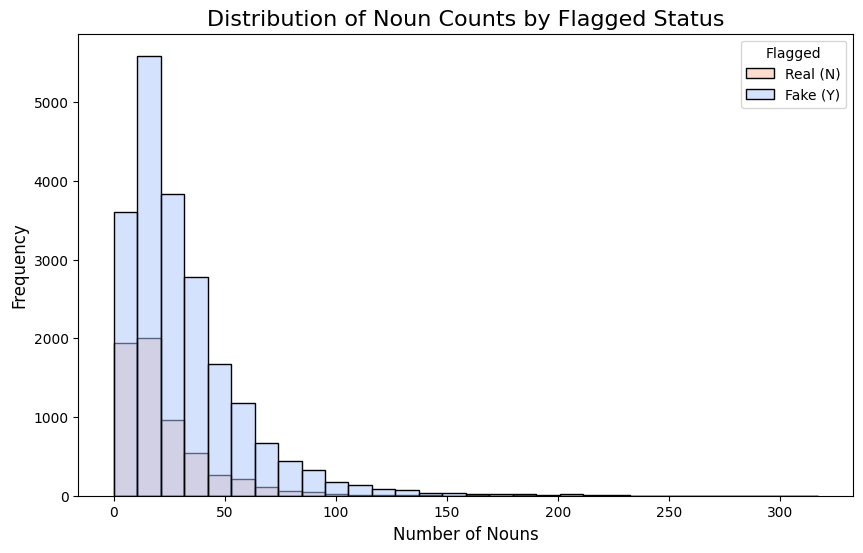

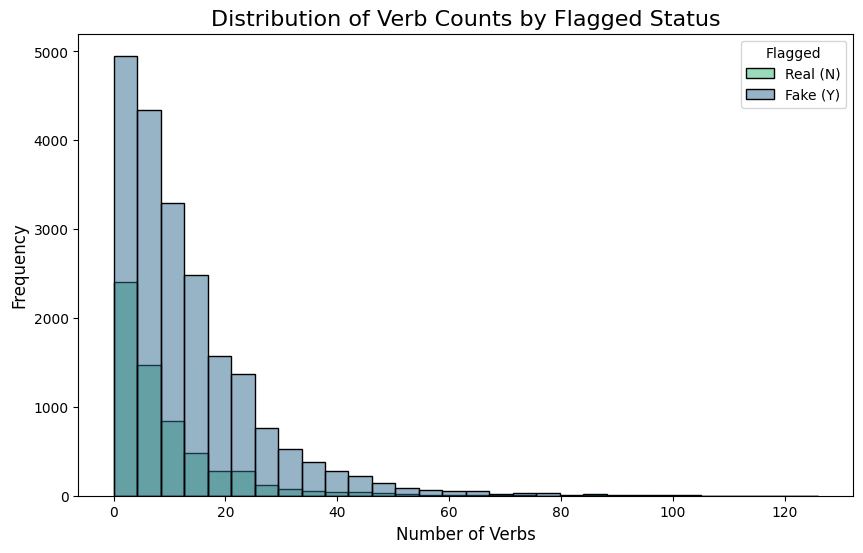

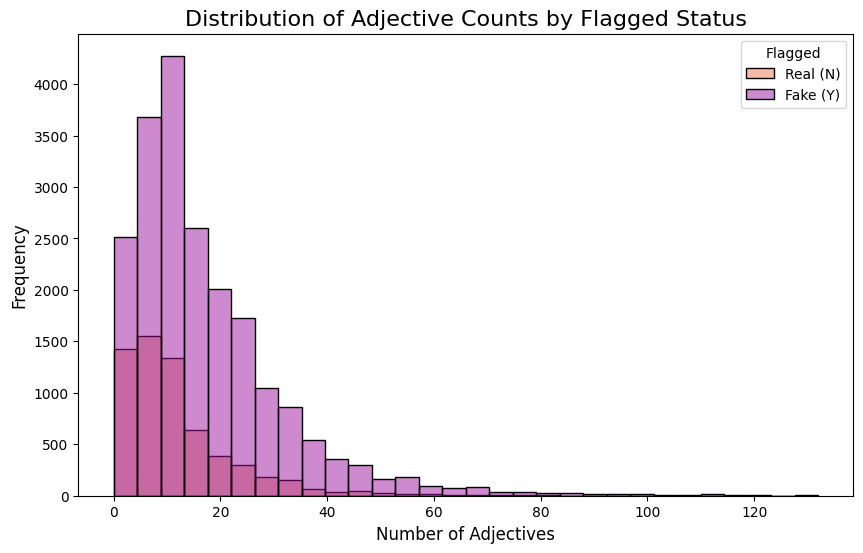

In [76]:
# Visualize noun count distribution by flagged status with proper legend
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='noun_count', bins=30, hue='flagged', palette='coolwarm', common_norm=False)
plt.title('Distribution of Noun Counts by Flagged Status', fontsize=16)
plt.xlabel('Number of Nouns', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(title='Flagged', labels=['Real (N)', 'Fake (Y)'])
plt.show()

# Visualize verb count distribution by flagged status with proper legend
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='verb_count', bins=30, hue='flagged', palette='viridis', common_norm=False)
plt.title('Distribution of Verb Counts by Flagged Status', fontsize=16)
plt.xlabel('Number of Verbs', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(title='Flagged', labels=['Real (N)', 'Fake (Y)'])
plt.show()

# Visualize adjective count distribution by flagged status with proper legend
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='adj_count', bins=30, hue='flagged', palette='plasma', common_norm=False)
plt.title('Distribution of Adjective Counts by Flagged Status', fontsize=16)
plt.xlabel('Number of Adjectives', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(title='Flagged', labels=['Real (N)', 'Fake (Y)'])
plt.show()

## Train Test Split 
stratify=y: Ensures that the train-test split maintains the same class distribution as the original dataset.

In [78]:
X = df.drop(columns=['flagged']) 
y = df['flagged']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Check class distribution in train and test sets
print("Class distribution in original data:", y.value_counts(normalize=True))
print("Class distribution in training data:", y_train.value_counts(normalize=True))
print("Class distribution in test data:", y_test.value_counts(normalize=True))

Class distribution in original data: flagged
N    0.769882
Y    0.230118
Name: proportion, dtype: float64
Class distribution in training data: flagged
N    0.769866
Y    0.230134
Name: proportion, dtype: float64
Class distribution in test data: flagged
N    0.769944
Y    0.230056
Name: proportion, dtype: float64


## Feature Engineering 
Feature engineering operations (encoding, scaling etc) are fitted on X_train and apply the transformation to the X_train_balanced and X_test. This is to avoid : 
* X_train_balanced : This ensures that the transformations reflect the true distribution of the original data and prevents biases introduced by synthetic data in the oversampling process.
* X_test : data leakage. if feature engineering is done before splitting, the test data would indirectly influence the scaling parameters (mean, standard deviation, min/max), leading to data leakage. This invalidates the test set’s role as unseen data for model evaluation.

Feature Engineering operations : 
* One Hot Encoding : Converts categorical variables into numerical representations.
* Mix-Max Scaling


### One-Hot Encoding
One hot encode categorical features : 
* Rating 
* State

In [79]:
categorical_columns = ['rating', 'state']

In [80]:
# Initialize OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit and transform training data
encoded_columns_train = ohe.fit_transform(X_train[categorical_columns])
encoded_df_train = pd.DataFrame(
    encoded_columns_train, 
    columns=ohe.get_feature_names_out(categorical_columns),
    index=X_train.index
)

# Transform testing data
encoded_columns_test = ohe.transform(X_test[categorical_columns])
encoded_df_test = pd.DataFrame(
    encoded_columns_test, 
    columns=ohe.get_feature_names_out(categorical_columns),
    index=X_test.index
)

# Drop original categorical columns from train and test datasets
X_train = X_train.drop(columns=categorical_columns)
X_test = X_test.drop(columns=categorical_columns)

# Concatenate the encoded columns back to train and test datasets
X_train = pd.concat([X_train.reset_index(drop=True), encoded_df_train.reset_index(drop=True)], axis=1)
X_test = pd.concat([X_test.reset_index(drop=True), encoded_df_test.reset_index(drop=True)], axis=1)

## Scaling

Min-Max Scaling: Rescales the data to fit within a desired range (e.g., [0, 1]) while preserving the relative distances between values. Helps for interpretability too

In [81]:
X_train.columns

Index(['reviewContent', 'yelpJoinYear', 'yelpJoinMonth', 'dateYear',
       'dateMonth', 'log_usefulCount_review', 'log_coolCount_review',
       'log_funnyCount_review', 'log_friendCount', 'log_firstCount',
       'log_tipCount', 'log_fanCount', 'word_count', 'char_count', 'polarity',
       'subjectivity', 'noun_count', 'verb_count', 'adj_count', 'rating_1',
       'rating_2', 'rating_3', 'rating_4', 'rating_5', 'state_AZ', 'state_CA',
       'state_CO', 'state_DC', 'state_FL', 'state_GA', 'state_IL', 'state_IN',
       'state_MA', 'state_MI', 'state_MN', 'state_MO', 'state_NY', 'state_OH',
       'state_Other', 'state_PA', 'state_TX', 'state_VA', 'state_WA',
       'state_WI'],
      dtype='object')

In [82]:
numerical_columns_to_scale = [
  'log_usefulCount_review', 
  'log_coolCount_review',
  'log_funnyCount_review',
  'log_friendCount',
  'log_firstCount',
  'log_tipCount',
  'log_fanCount',
  'word_count',
  'char_count',
  'polarity',
  'subjectivity',
  'noun_count',
  'verb_count',
  'adj_count'
]

In [83]:
scaler = StandardScaler()

X_train[numerical_columns_to_scale] = scaler.fit_transform(X_train[numerical_columns_to_scale])

X_test[numerical_columns_to_scale] = scaler.transform(X_test[numerical_columns_to_scale])